### Testing Evo

#### Imports

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import torch_geometric
from torch_geometric.nn import GCNConv
import IPython
from IPython.display import display, HTML, Image
from torch_geometric.loader import DataLoader

from generator import generate_organism
from cell import Cell
from organism import Organism
from GNCAmodel import GNCA
from visualizer import Visualizer
from evo_trainer import Evo_Trainer

%run graphUtils.py
%run Visualizer.py # --allows for reloading the particular code
#%run CGConv.py

#### Train the network

In [2]:
n = 10
popsize = 10
generations = 500
batch_size = 8
wrap_around = True
with_global_node = True
food_amount = 50
name = 'centered17'
#device = torch.device('mps')
device = torch.device('cpu')
trainer = Evo_Trainer(n, device, batch_size, True, with_global_node, food_amount, popsize)

2023-03-22 07:59:51,874	INFO worker.py:1528 -- Started a local Ray instance.


[2023-03-22 07:59:54] INFO     <50771> evotorch.core: Instance of `Custom_NEProblem` (id:4402544256) -- The `dtype` for the problem's decision variables is set as torch.float32
[2023-03-22 07:59:54] INFO     <50771> evotorch.core: Instance of `Custom_NEProblem` (id:4402544256) -- `eval_dtype` (the dtype of the fitnesses and evaluation data) is set as torch.float32
[2023-03-22 07:59:54] INFO     <50771> evotorch.core: Instance of `Custom_NEProblem` (id:4402544256) -- The `device` of the problem is set as cpu
[2023-03-22 07:59:54] INFO     <50771> evotorch.core: Instance of `Custom_NEProblem` (id:4402544256) -- The number of actors that will be allocated for parallelized evaluation is 10
[2023-03-22 07:59:54] INFO     <50771> evotorch.core: Instance of `Custom_NEProblem` (id:4402544256) -- Number of GPUs that will be allocated per actor is None


/Users/martinholst/miniconda3/envs/AML/lib/python3.10/site-packages/evotorch/tools/misc.py:1107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result = torch.tensor(data, **kwargs)


In [3]:
#[trainer.searcher.before_step_hook() for i in range(100)]

In [34]:
trainer.train(generations, name)

         iter : 1001
     stepsize : ReadOnlyTensor(0.0263)
  median_eval : 29.326467514038086
pop_best_eval : 35.04964828491211
    mean_eval : 26.821269989013672

         iter : 1002
     stepsize : ReadOnlyTensor(0.0263)
  median_eval : 28.3839168548584
pop_best_eval : 42.703678131103516
    mean_eval : 29.3834285736084

         iter : 1003
     stepsize : ReadOnlyTensor(0.0263)
  median_eval : 24.324968338012695
pop_best_eval : 33.52189636230469
    mean_eval : 24.628747940063477

         iter : 1004
     stepsize : ReadOnlyTensor(0.0263)
  median_eval : 25.351200103759766
pop_best_eval : 31.099470138549805
    mean_eval : 23.896556854248047

         iter : 1005
     stepsize : ReadOnlyTensor(0.0263)
  median_eval : 24.89531898498535
pop_best_eval : 36.23557662963867
    mean_eval : 26.75918960571289

         iter : 1006
     stepsize : ReadOnlyTensor(0.0263)
  median_eval : 26.887577056884766
pop_best_eval : 32.43239974975586
    mean_eval : 26.713329315185547

         iter 

In [21]:
network = trainer.get_trained_network()

In [22]:
#trainer.logger_df.from_csv('../logger/' + name + '.csv')
network.load_state_dict(torch.load('../models/' + name + '.pth'))

<All keys matched successfully>

In [23]:
#network = trainer.problem.parameterize_net(trainer.searcher.status['best'][0])
network = trainer.problem.parameterize_net(trainer.searcher.status['center'][0])
#network = trainer.problem.parameterize_net(trainer.searcher.status['obj0_pop_best'])

In [24]:
#trainer.searcher.status

#### Visualize trained network

In [25]:
v_batch_size= 8
graphs = [generate_organism(n, device, with_global_node, food_amount).toGraph() for _ in range(v_batch_size)]
loader = DataLoader(graphs, batch_size=v_batch_size)
graph = next(iter(loader))
visualizer = Visualizer(wrap_around, v_batch_size)
network.batch_size = v_batch_size
network(graph, 0)

DataBatch(x=[488, 5], edge_index=[1, 0], device=[8], subsize=[8], energy=[8], velocity=[8], border_cost=[8], food_reward=[8], dead_cost=[8], visible_food=[8], food_avg_dist=[8], food_avg_degree=[8], food_search_movement=[8], batch=[488], ptr=[9])

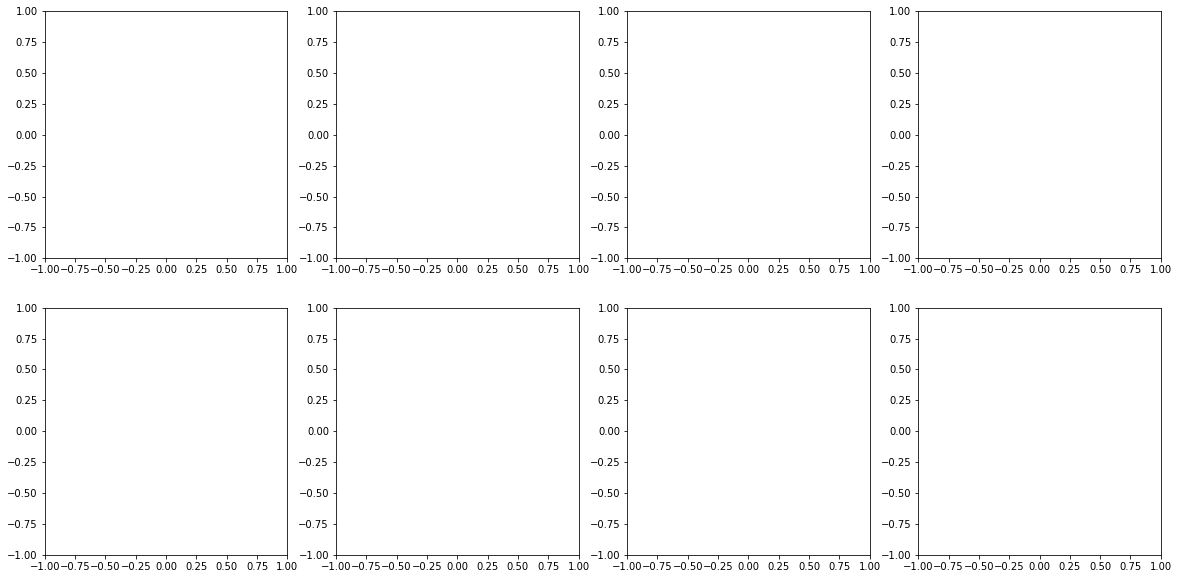

In [26]:
anim = visualizer.animate_organism(graph, network, food=30, frames=200)
visualizer.save_animation_to_gif(anim, name, fps=10, dpi=50)

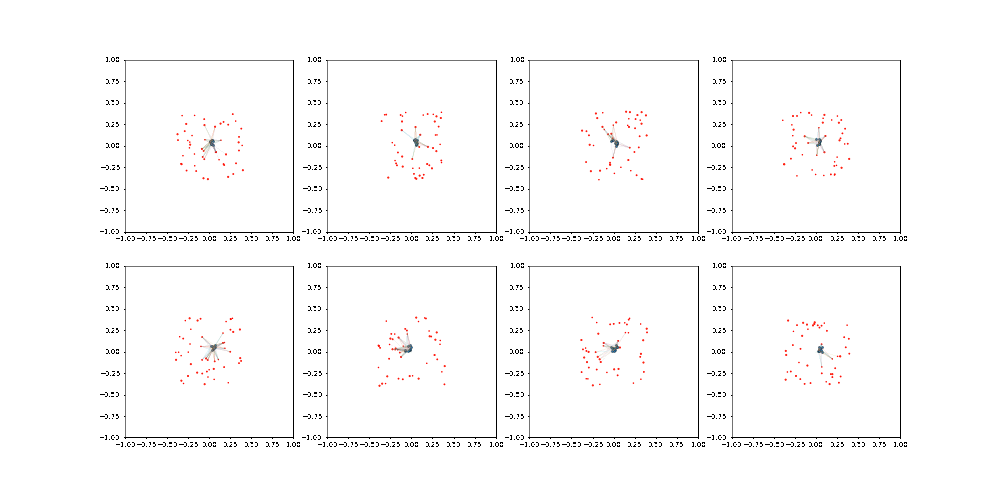

In [27]:
Image('../animation/' + name + '.gif')

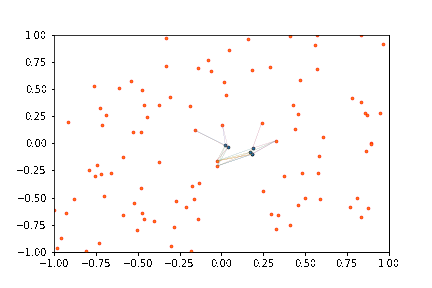

In [28]:
Image('../animation/GATConv1.gif')

In [29]:
#anim.frame_seq = anim.new_saved_frame_seq() 
#IPython.display.HTML(anim.to_jshtml())

In [30]:
print(network)

Conv(
  (conv_layer_food): CustomConvSimple(2, dim=3)
  (conv_layer_cell): CustomConvSimple(2, dim=3)
  (conv_layer_global): CustomConvSimple(2, dim=3)
  (gConvGRU): GConvGRU(
    (conv_x_z): ChebConv(6, 6, K=1, normalization=sym)
    (conv_h_z): ChebConv(6, 6, K=1, normalization=sym)
    (conv_x_r): ChebConv(6, 6, K=1, normalization=sym)
    (conv_h_r): ChebConv(6, 6, K=1, normalization=sym)
    (conv_x_h): ChebConv(6, 6, K=1, normalization=sym)
    (conv_h_h): ChebConv(6, 6, K=1, normalization=sym)
  )
  (mlp_before): Sequential(
    (0): Linear(in_features=2, out_features=2, bias=True)
    (1): Tanh()
  )
  (conv_layer_cells): CustomConvSimple(2, dim=3)
)


In [31]:
print('GConvGRU: ', network.gConvGRU)
for param in network.gConvGRU.parameters():
  print(param.data)


GConvGRU:  GConvGRU(
  (conv_x_z): ChebConv(6, 6, K=1, normalization=sym)
  (conv_h_z): ChebConv(6, 6, K=1, normalization=sym)
  (conv_x_r): ChebConv(6, 6, K=1, normalization=sym)
  (conv_h_r): ChebConv(6, 6, K=1, normalization=sym)
  (conv_x_h): ChebConv(6, 6, K=1, normalization=sym)
  (conv_h_h): ChebConv(6, 6, K=1, normalization=sym)
)
tensor([-0.2181, -0.1393,  0.4985, -0.3932,  0.3674,  0.6370])
tensor([[-7.8578e-01, -1.6620e-01,  5.4268e-01, -3.0926e-01, -4.4961e-01,
         -1.1445e+00],
        [-1.1485e-01,  8.2860e-01,  2.2720e-01,  3.7956e-01,  6.9276e-02,
         -1.2918e-01],
        [ 1.2700e+00,  1.7131e-01, -7.0321e-02,  1.5756e-04,  8.9383e-02,
          1.5000e-01],
        [ 4.1521e-01, -3.9081e-01, -8.1071e-01, -4.6913e-01, -5.4609e-01,
         -3.7458e-01],
        [ 1.3617e-01, -2.4354e-02,  9.1195e-02, -4.9540e-02,  1.7771e-02,
         -3.5061e-02],
        [ 2.0895e-01,  6.7111e-01,  4.7146e-01, -7.4469e-01, -6.7210e-02,
          8.1334e-01]])
tensor([ 0.53

In [32]:
%%javascript
IPython.notebook.save_notebook()

<IPython.core.display.Javascript object>

#### Visualization of loss:

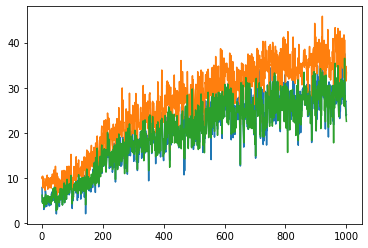

In [ ]:
import matplotlib.pyplot as plt
losses = trainer.logger_df
#print(losses)
#plt.plot(losses.stepsize)

plt.plot(losses.median_eval)
plt.plot(losses.pop_best_eval)
plt.plot(losses.mean_eval)
#plt.legend(('median_eval', 'pop_best_eval', 'mean eval'))
plt.show()

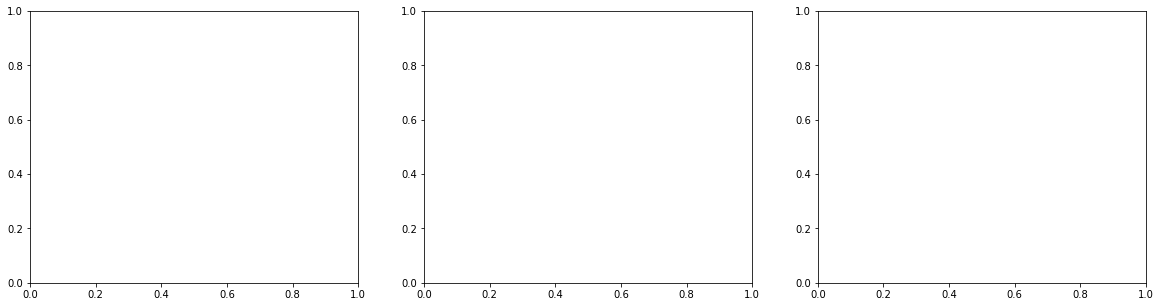

In [18]:
trainer.logger_df
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
fig.suptitle('')
plt.show()

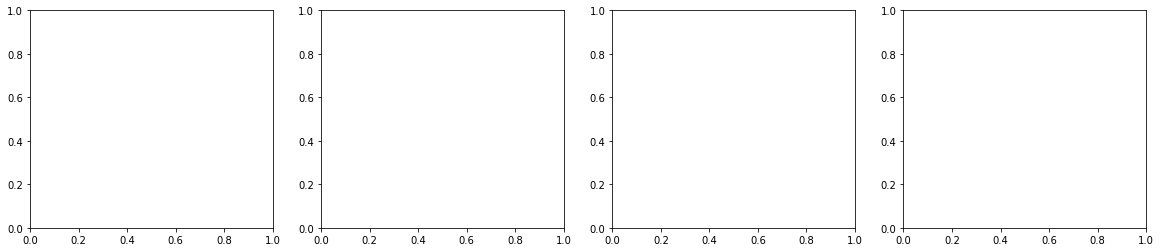

In [19]:
fig, axs = plt.subplots(1, 4, figsize=(20,4))